In [2]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.stats
import os
import os.path

import scipy
from scikits import bootstrap as bootstrap
from collections import *
from scipy.interpolate import spline

from bs4 import BeautifulSoup
import urlparse
from urllib2 import urlopen
from urllib import urlretrieve
import urllib
import os
import sys
import re

from leven import levenshtein       
import numpy as np
from sklearn.cluster import dbscan

from fuzzywuzzy import fuzz
import textwrap


In [37]:
def awesome_plot(big_df, x, y, hue, col=None, smoothing=1, n_samples=10000, xlabel='', ylabel='', relabeling=None):

    def my_bootstrap(x):
        try:
            return bootstrap.ci(data=x, statfunction=scipy.mean, n_samples=n_samples)
        except:
            m = scipy.mean(x)
            return (m, m)

    
    # Pre-split into different columns
    cols = [ (None, big_df)]
    if col is not None:
        cols = []
        col_names = set(big_df[col])
        for cname in col_names:
            cols.append((cname, big_df[big_df[col] == cname]))
            
    for (col_name, col_df) in cols:
    
        hues_names = set(col_df[hue])
        attr_data = []
        fig1 = plt.figure()

        for hue_name in hues_names:
            df = col_df[col_df[hue] == hue_name]

            # Get the actual mean at each year
            y1_mean = df.groupby([x], as_index=False)[y].mean()
            y1_cis = df.groupby([x], as_index=False)[y].apply(lambda x:my_bootstrap(x))
            #print y1_cis
            attr_data.append((y1_mean, y1_cis, hue_name))
            
        # EWM = Exponentially-Weighted Mean, which is what we use for smooth.  Set this to 1 for no smoothing
        ewm_span = smoothing

        # Get the upper and lower bound for the confidence intervals
        for j, (attr_mean, attr_cis, attr_name) in enumerate(attr_data):
            EwmAcc = attr_mean[y].ewm(span=ewm_span).mean()
            
            upper_bound = []
            lower_bound = []
            eb_df_data = {'Upper Bound': upper_bound, 'Lower Bound': lower_bound}
    
            for i in range(0, len(attr_cis)):
                lower_bound.append(attr_cis[i][0])
                upper_bound.append(attr_cis[i][1])

            eb_df = pd.DataFrame(eb_df_data, columns = ['Upper Bound', 'Lower Bound'])
            attr_mean['Ewm Mean'] = EwmAcc
            attr_mean['Ewm UB'] = eb_df['Upper Bound'].ewm(span=ewm_span).mean()
            attr_mean['Ewm LB'] = eb_df['Lower Bound'].ewm(span=ewm_span).mean()
            
            #print attr_mean.head(100)
            
        colors = ['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e','#e6ab02']        
        styles = ['-', '--', '-.', ':', '-']
        for j, (attr_mean, attr_cis, attr_name) in enumerate(attr_data):
            # print col_name, attr_name
 
            label = attr_name
            if relabeling is not None:
                if label in relabeling:
                    label = relabeling[label]

            plt.plot(attr_mean[x], attr_mean['Ewm Mean'], \
                     label=label, color=colors[j % len(colors)], ls=styles[j % len(styles)])
        
            plt.fill_between(attr_mean[x], attr_mean['Ewm LB'], attr_mean['Ewm UB'], \
                             interpolate=False, alpha=0.1, edgecolor=None, \
                             color=colors[j % len(colors)])
    
        plt.legend(ncol=1, fontsize=14, loc='upper left', bbox_to_anchor=(1., 0.8))
        plt.gca().set_axis_bgcolor('white')
        if col_name is not None:
            plt.suptitle(col + ' = ' + str(col_name))


        ax = plt.gca()
        # 'Reproductive Success Rate\n(what % of graduates have children)'
        ax.set_ylabel(ylabel, fontsize=22)
        ax.set_xlabel(xlabel, fontsize=22)  
        ax.grid(False)
        plt.tight_layout()   

In [ ]:
def percent_sample_awesome_plot(big_df, x, y, hue, col=None, smoothing=1, n_samples=10000, xlabel='', ylabel='', relabeling=None):
    

In [26]:
citing_to_typed_cited = defaultdict(set)
cited_to_citing = defaultdict(set)
cited_to_typed_citing = defaultdict(set)

with open('../results/citation-graph/v5/cite-func.all.tsv') as f:    
    for line in f: 
        cols = line[:-1].split('\t')
        citing = cols[0][:8]
        cited = cols[1]
        function = cols[2]
        citing_to_typed_cited[citing].add((cited, function))
        
        if 'xternal' not in cited:
            cited_to_citing[cited].add(citing)
            cited_to_typed_citing[cited].add((citing, function))

In [28]:
all_papers = [x for x in set(citing_to_typed_cited.iterkeys()) | set(cited_to_citing.iterkeys()) if not 'xtern' in x]
paper_to_year = {}
for p in all_papers:
    y = int(p[1:3])
    if y < 50:
        y += 2000
    else:
        y += 1900
    paper_to_year[p] = y

In [29]:
how_citing_df = []
how_citing_counter = Counter()
how_citing_sum_counter = Counter()

for citing, typed_cited in citing_to_typed_cited.iteritems():    
    citing_year = paper_to_year[citing]
    venue = citing[0]
    
    for tc in typed_cited:
        func = tc[1]
        how_citing_counter[(venue, func, citing_year)] += 1
        how_citing_sum_counter[(venue, citing_year)] += 1
        
for (venue, func, citing_year), count in how_citing_counter.iteritems():
        how_citing_df.append({
            'venue': venue,
            'citation function': func,
            'year': citing_year,
            'count': count,
            'percentage': float(count) / how_citing_sum_counter[(venue, citing_year)],
        })

how_citing_df = pd.DataFrame(how_citing_df)        

In [112]:
how_cited_df = []
how_cited_counter = Counter()
how_cited_sum_counter = Counter()

for citing, typed_cited in citing_to_typed_cited.iteritems():    
    citing_year = paper_to_year[citing]
    for tc in typed_cited:
        venue = tc[0][0]
        func = tc[1]
        how_cited_counter[(venue, func, citing_year)] += 1
        how_cited_sum_counter[(venue, citing_year)] += 1

        
for (venue, func, citing_year), count in how_cited_counter.iteritems():
        how_cited_df.append({
            'venue': venue,
            'citation function': func,
            'year': citing_year,
            'count': count,
            'percentage': float(count) / how_cited_sum_counter[(venue, citing_year)],
        })

how_cited_df = pd.DataFrame(how_cited_df)        

In [30]:
g = sns.factorplot(x="year", y="percentage", col="venue",  data=how_cited_df[how_cited_df['venue'] == 'D'],
                   hue='citation function', col_wrap=2, sharey=False, sharex=False,
                   palette='Set2')

NameError: name 'how_cited_df' is not defined

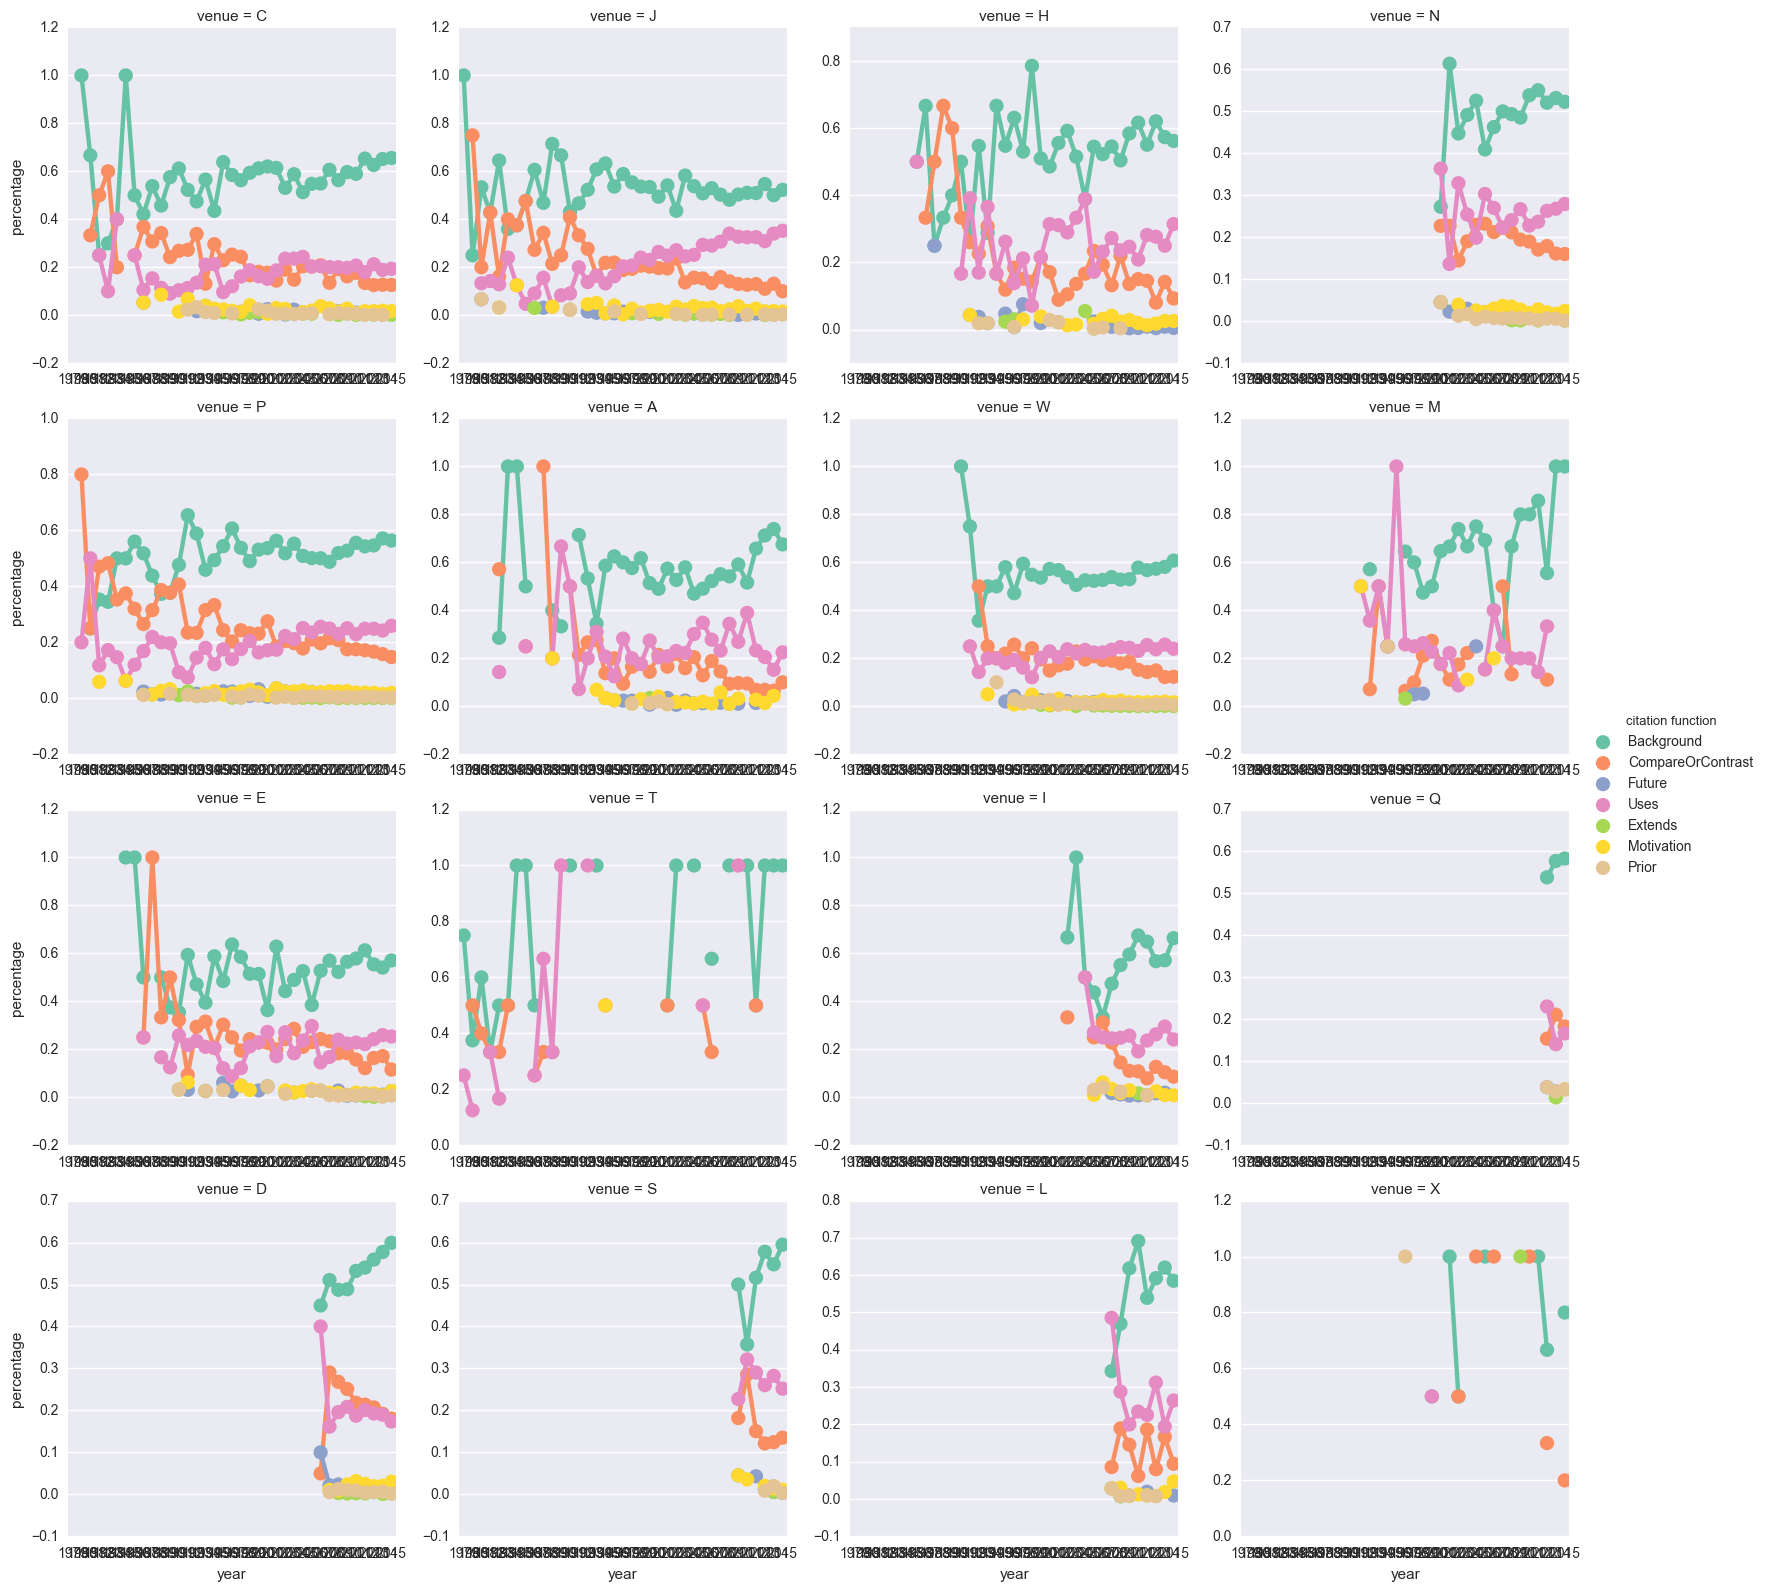

In [114]:
g = sns.factorplot(x="year", y="percentage", col="venue",  data=how_cited_df,
                   hue='citation function', col_wrap=4, sharey=False, sharex=False,
                   palette='Set2')

In [35]:
workshop_how_citing_df = []
workshop_how_citing_counter = Counter()
workshop_how_citing_sum_counter = Counter()

funcs = set()
workshop_to_years = defaultdict(list)

for citing, typed_cited in citing_to_typed_cited.iteritems():    
    citing_year = paper_to_year[citing]
    venue_prefix = citing[0:6]
    if venue_prefix not in prefix_to_workshop:
        continue    
    for tc in typed_cited:
        workshop = prefix_to_workshop[venue_prefix]
        func = tc[1]
        funcs.add(func)
        workshop_to_years[workshop].append(citing_year)
        workshop_how_citing_counter[(workshop, func, citing_year)] += 1
        workshop_how_citing_sum_counter[(workshop, citing_year)] += 1

for workshop, years in workshop_to_years.iteritems():
    for citing_year in range(min(years), max(years)+1):
        
        # Check the workshop occurred that year
        tmp_sum = 0
        for func in funcs:
            tmp_sum += workshop_how_citing_counter[(workshop, func, citing_year)]
        if tmp_sum == 0:
            continue
        
        for func in funcs:
            count = workshop_how_citing_counter[(workshop, func, citing_year)]
            perc = 0
            csum = workshop_how_citing_sum_counter[(workshop, citing_year)]
            if csum > 0:
                perc = float(count) / csum
            workshop_how_citing_df.append({
                    'workshop': workshop,
                    'citation function': func,
                    'year': citing_year,
                    'count': count,
                    'percentage': perc,
            })

workshop_how_citing_df = pd.DataFrame(workshop_how_citing_df)        

In [167]:
workshop_how_cited_df = []
workshop_how_cited_counter = Counter()
workshop_how_cited_sum_counter = Counter()

funcs = set()
workshop_to_years = defaultdict(list)

for citing, typed_cited in citing_to_typed_cited.iteritems():    
    citing_year = paper_to_year[citing]
    for tc in typed_cited:
        venue_prefix = tc[0][0:6]
        #if venue_prefix == 'W09-04':
        #    print venue_prefix
        if venue_prefix not in prefix_to_workshop:
            #if venue_prefix[0] == 'W':
            #    print 'missing', venue_prefix
            continue
        workshop = prefix_to_workshop[venue_prefix]
        func = tc[1]
        funcs.add(func)
        workshop_to_years[workshop].append(citing_year)
        workshop_how_cited_counter[(workshop, func, citing_year)] += 1
        workshop_how_cited_sum_counter[(workshop, citing_year)] += 1

for workshop, years in workshop_to_years.iteritems():
    for citing_year in range(min(years), max(years)+1):
        for func in funcs:
            count = workshop_how_cited_counter[(workshop, func, citing_year)]
            perc = 0
            csum = workshop_how_cited_sum_counter[(workshop, citing_year)]
            if csum > 0:
                perc = float(count) / csum
            workshop_how_cited_df.append({
                'workshop': workshop,
                'citation function': func,
                'year': citing_year,
                'count': count,
                'percentage': perc,
        })

workshop_how_cited_df = pd.DataFrame(workshop_how_cited_df)        

In [169]:
workshop_how_cited_df.head()
tmp_w_df = workshop_how_cited_df[workshop_how_cited_df['workshop'] == 'Statistical Machine Translation']
tmp_w_df.head()

,citation function,count,percentage,workshop,year
1281,Motivation,0,0.0,Statistical Machine Translation,2006
1282,Prior,0,0.0,Statistical Machine Translation,2006
1283,Future,0,0.0,Statistical Machine Translation,2006
1284,Uses,0,0.0,Statistical Machine Translation,2006
1285,Background,0,0.0,Statistical Machine Translation,2006


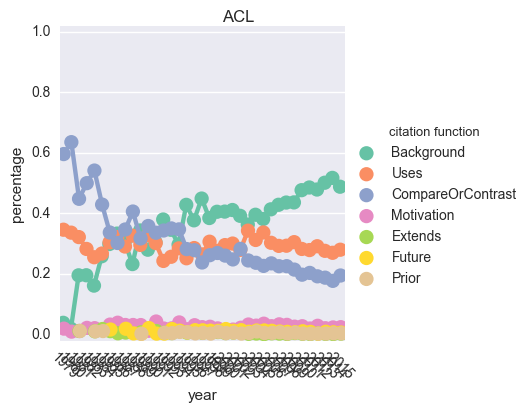

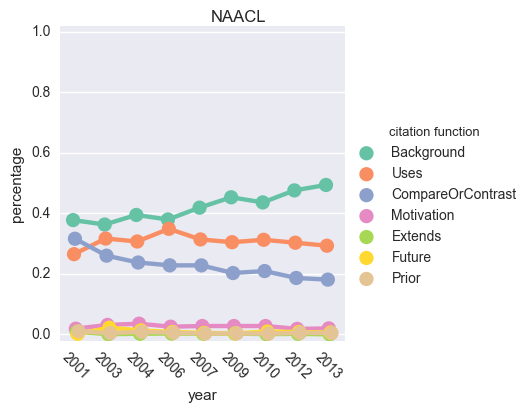

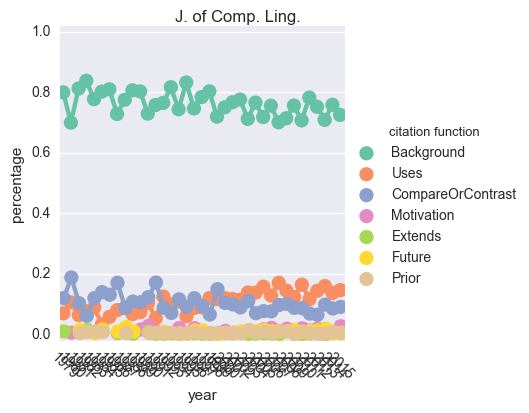

In [32]:
custom_venues = ['P', 'N', 'J']
#workshops = ['Reordering for Statistical Machine Translation']

name_map = {'P': "ACL", 'N': "NAACL", 'J': 'J. of Comp. Ling.'}

for venue in custom_venues:
    w_df = how_citing_df[how_citing_df['venue'] == venue]
    #print w_df.head()
    g = sns.factorplot(x="year", y="percentage", title=w, data=w_df, ci=None, 
                       hue_order=['Background', 'Uses', 'CompareOrContrast', 'Motivation', 'Extends', 'Future', 'Prior'],
                       hue='citation function', dodge=True, palette='Set2')
    g.fig.suptitle(name_map[venue])
    g.set_xticklabels(rotation=-45)
    plt.ylim(-0.02, 1.02)
    #break

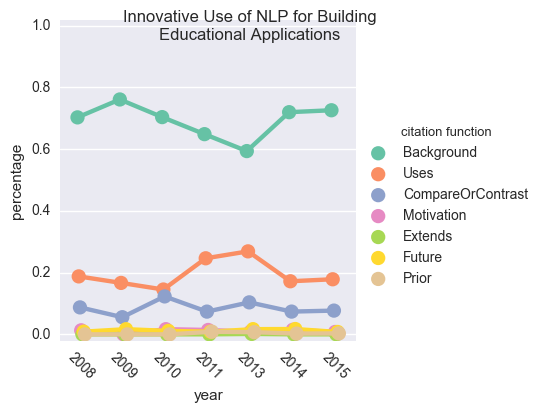

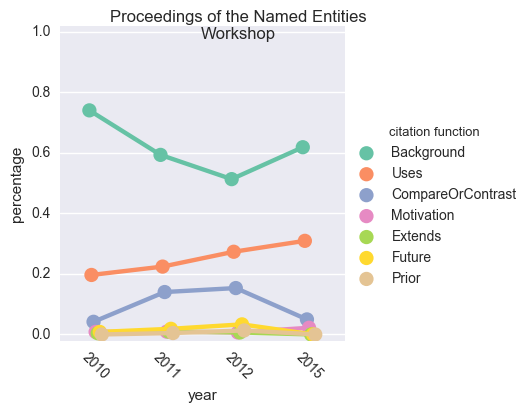

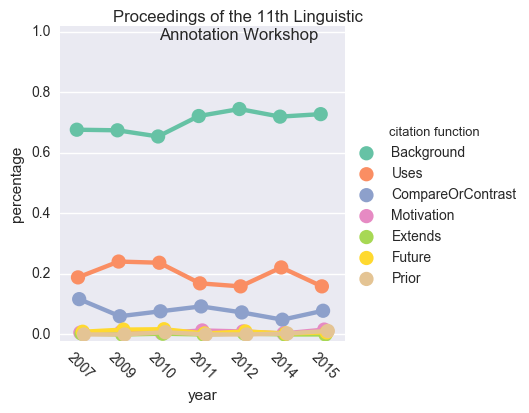

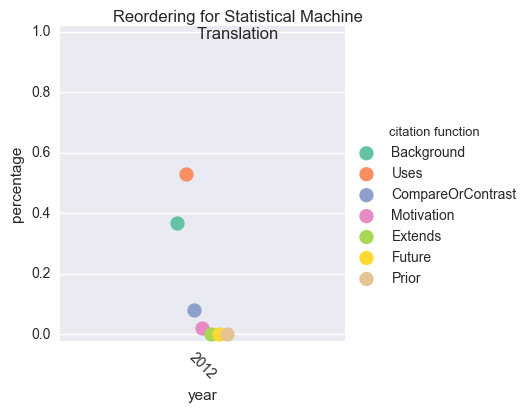

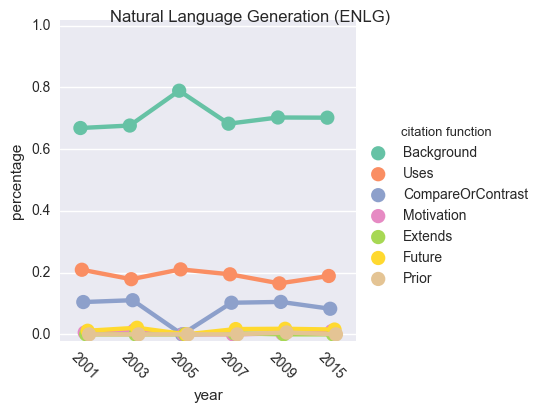

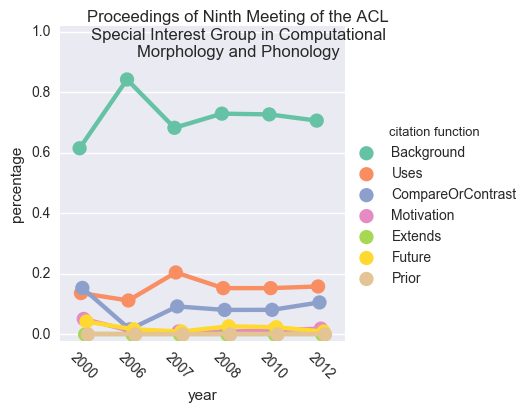

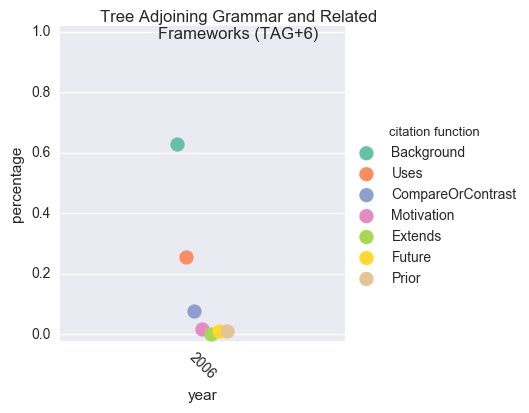

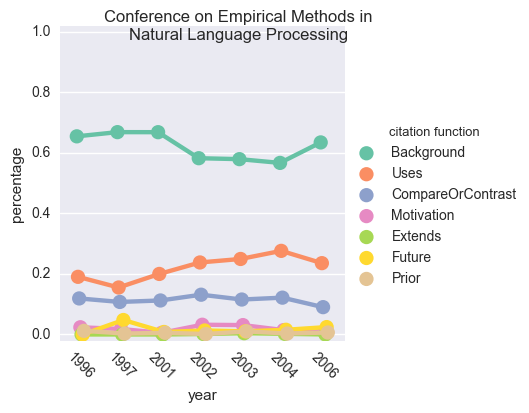

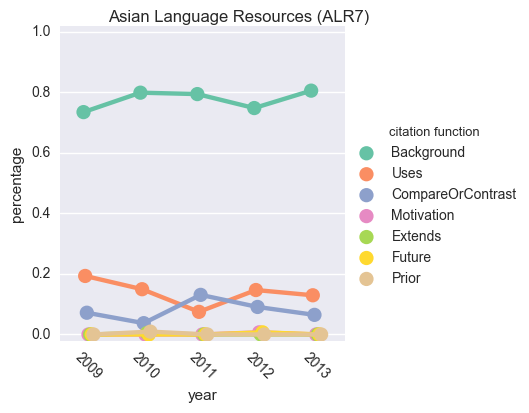

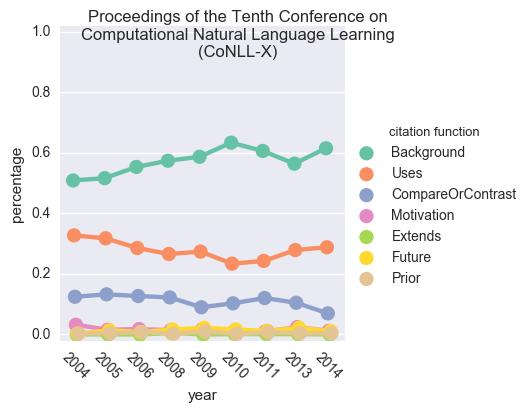

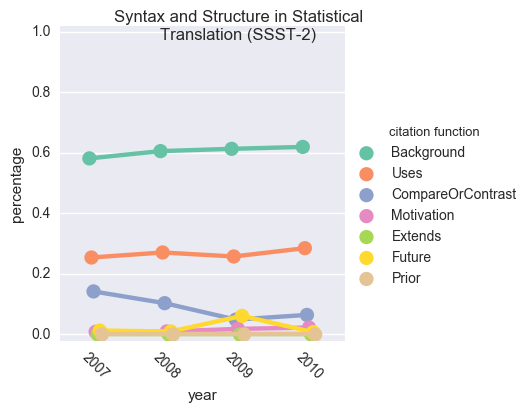

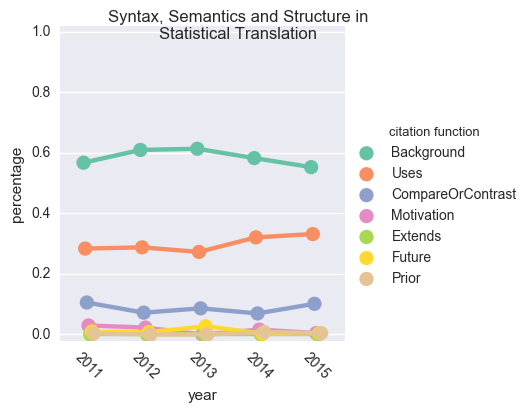

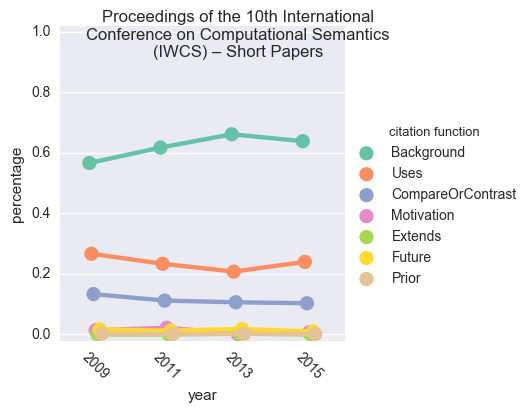

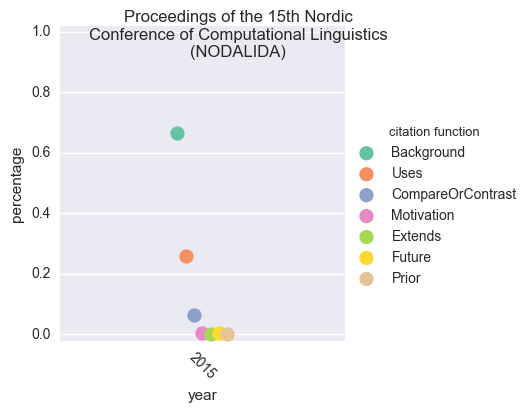

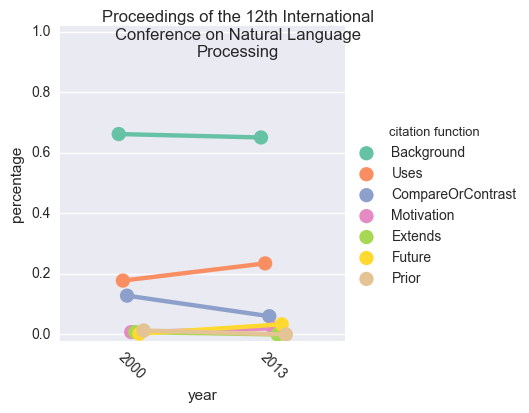

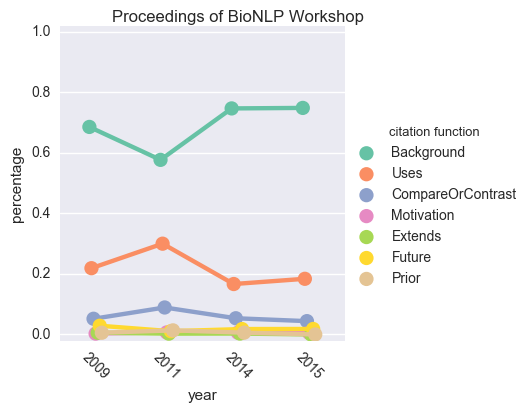

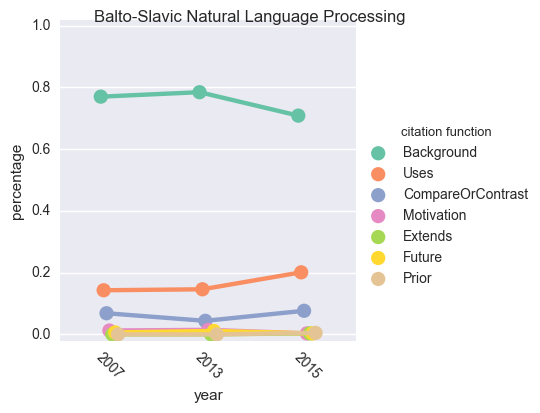

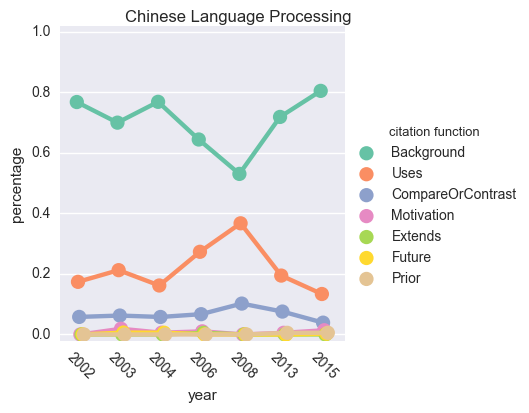

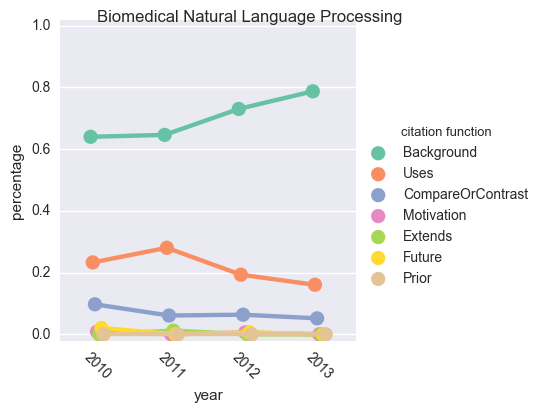

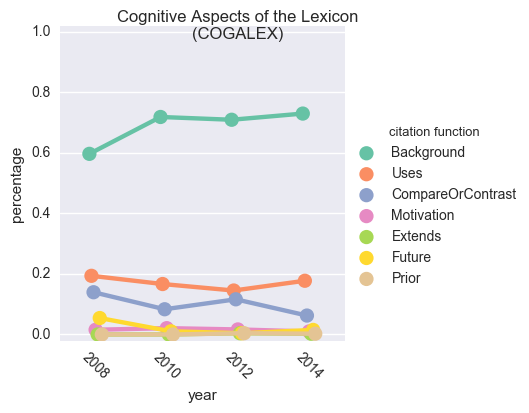

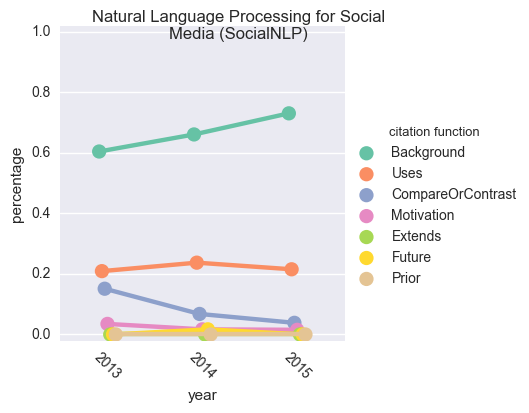

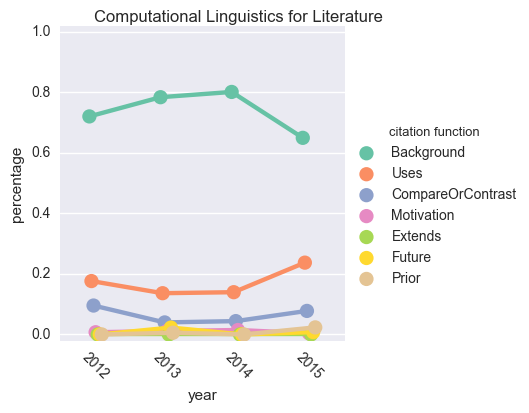

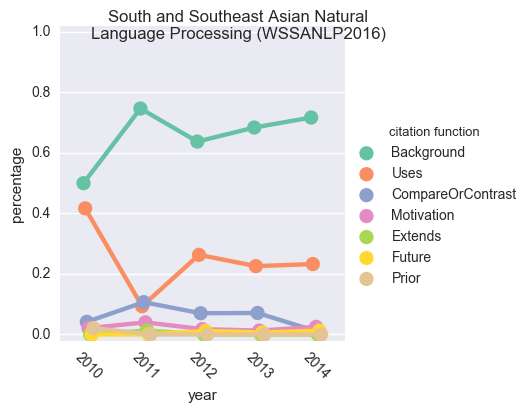

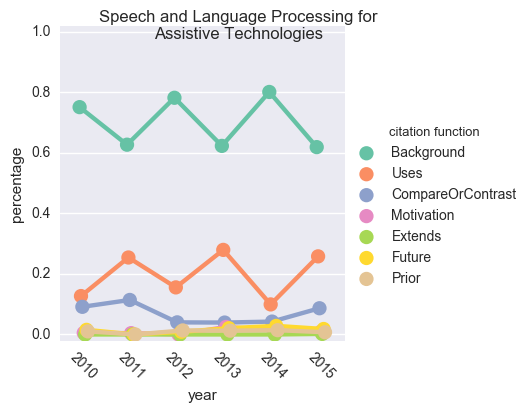

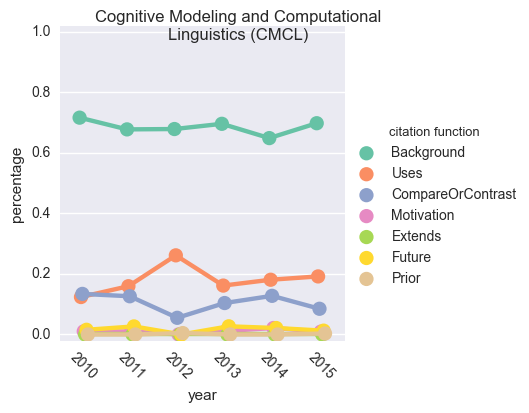

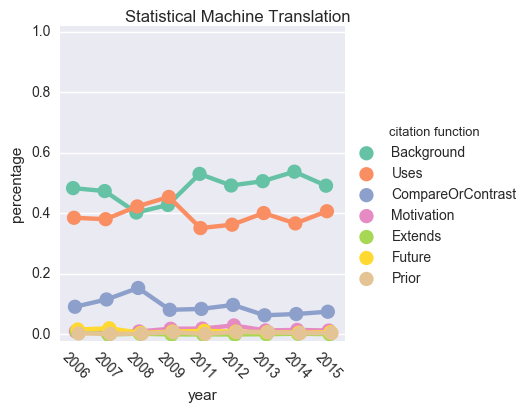

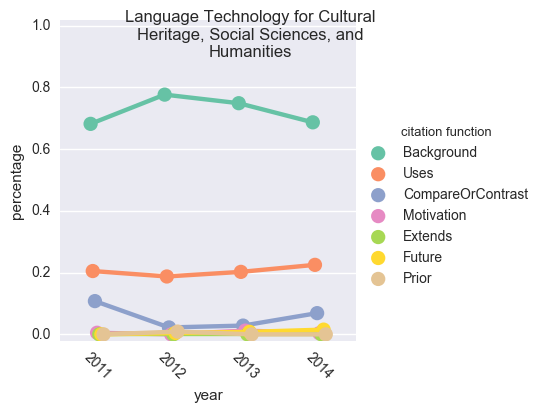

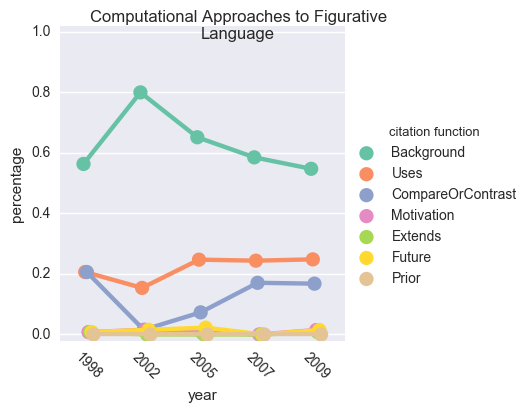

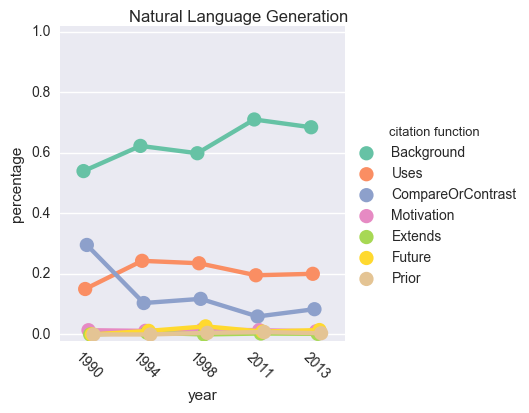

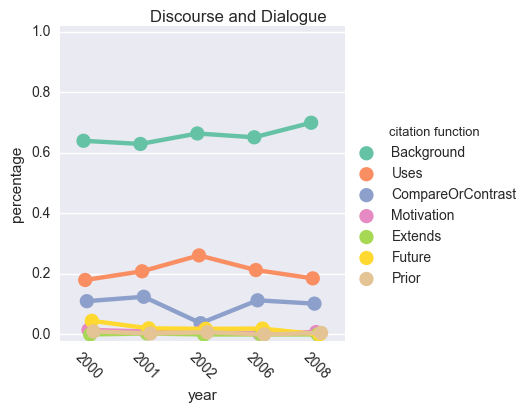

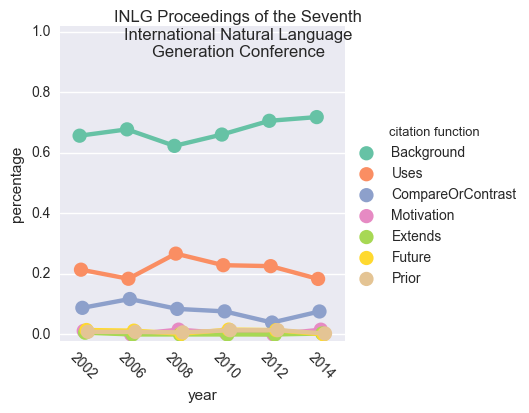

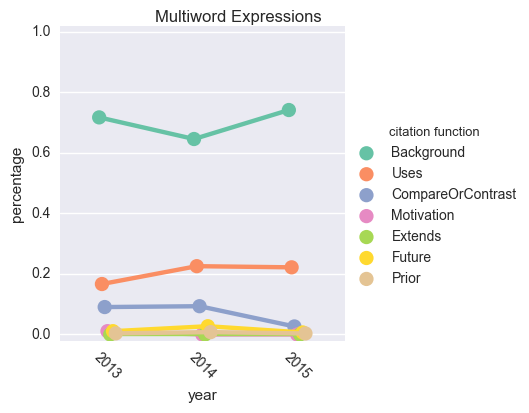

In [36]:
workshops = set(workshop_how_citing_df['workshop'])
#workshops = ['Reordering for Statistical Machine Translation']

for w in workshops:
    w_df = workshop_how_citing_df[workshop_how_citing_df['workshop'] == w]
    #print w_df.head()
    g = sns.factorplot(x="year", y="percentage", title=w, data=w_df, ci=None,
                       hue_order=['Background', 'Uses', 'CompareOrContrast', 'Motivation', 'Extends', 'Future', 'Prior'],
                       hue='citation function', dodge=True, palette='Set2')
    g.fig.suptitle(textwrap.fill(w, 40).decode('utf-8'))
    g.set_xticklabels(rotation=-45)
    plt.ylim(-0.02, 1.02)
    #break

# The code below attempts to automatically canonicalize a workshop across all its ACL venue prefixes (e.g., W01-01)

In [49]:
names_df = []
for year in range(1977, 2018):
    year = year % 100
    page = 'http://aclweb.org/anthology/W/W%02d/' % year
    #print page
    #page = 'http://aclweb.org/anthology/W/W01/'
    r = urllib.urlopen(page).read()
    soup = BeautifulSoup(r, "html.parser")
    links = soup.find_all("a")
    for link in links:
        #print link
        try:
            href = link["href"]
        except:
            continue
        text = link.get_text()
        if len(href) == 5:
            key = 'W%02d-%s' % (year, href[1:3])
            orig_text = text
            i = text.find('Workshop on ')
            if i > 0:
                text = text[i + len('Workshop on '):]
            text = re.sub(r' [0-9]{4}', '', text)
            print text, ' -> ', key
            names_df.append({'name': orig_text, 'cleaned name': text, 'prefix': key})
names_df = pd.DataFrame(names_df)
names_df.to_csv('../data/workshop-names.tsv', sep='\t', index=False, encoding='utf-8')

Natural Language Generation  ->  W90-01
Tree Adjoining Grammar and Related Frameworks (TAG+1)  ->  W90-02
Reversible Grammar in Natural Language Processing  ->  W91-01
Lexical Semantics and Knowledge Representation  ->  W91-02
Proceedings of the 8th Nordic Conference of Computational Linguistics (NODALIDA)  ->  W91-03
Acquisition of Lexical Knowledge from Text  ->  W93-01
Intentionality and Structure in Discourse Relations  ->  W93-02
VERY LARGE CORPORA: ACADEMIC AND INDUSTRIAL PERSPECTIVES  ->  W93-03
Proceedings of the 9th Nordic Conference of Computational Linguistics (NODALIDA)  ->  W93-04
The Balancing Act: Combining Symbolic and Statistical Approaches to Language  ->  W94-01
Computational Phonology  ->  W94-02
Natural Language Generation  ->  W94-03
Very Large Corpora  ->  W95-01
Proceedings of the 10th Nordic Conference of Computational Linguistics (NODALIDA)  ->  W95-02
Very Large Corpora  ->  W96-01
Conference on Empirical Methods in Natural Language Processing  ->  W96-02
Bre

In [9]:
names_df = pd.read_csv('../data/workshop-names.tsv', sep='\t')

In [10]:
names_df.head()
len(names_df)

743

In [11]:
print names_df.groupby('cleaned name')

#len(names_df.groupby('cleaned name'))

In [12]:
names = names_df['cleaned name']

#def lev_metric(x, y):
#    i, j = int(x[0]), int(y[0])     # extract indices
#    return levenshtein(names[i], names[j])

#X = np.arange(len(names)).reshape(-1, 1)
#fit = dbscan(X, metric=lev_metric, eps=5, min_samples=1)

In [13]:
#print fit
all_names = list(set(names))
clusters = []
unmatched = []
used = set()

for i, name in enumerate(all_names):
    if i in used:
        continue
    used.add(name)
    cluster = [ name ]
    for j, name2 in enumerate(all_names[i+1:]):
        if name2 in used:
            continue
        ratio = fuzz.ratio(name, name2)
        tr = fuzz.token_set_ratio(name, name2)
        if ratio > 80 and tr > 70:
            if 'Statistical Machine Translation' in name or 'Statistical Machine Translation' in name2:
                print name, name2, ratio, tr
            used.add(name2)
            cluster.append(name2)
    if len(cluster) > 1:
        clusters.append(cluster)
    else:
        unmatched.extend(cluster)

Reordering for Statistical Machine Translation Statistical Machine Translation 81 100
Semantics-Driven Statistical Machine Translation (S2MT) Semantics-Driven Machine Translation (SedMT) 85 92


In [162]:
for cluster in sorted_clusters:
    for c in cluster:
        if 'Semantics-Driven Statistical Machine Translation' in c:
            print cluster

[u'Semantics-Driven Statistical Machine Translation (S2MT)', u'Semantics-Driven Machine Translation (SedMT)']


In [17]:
name_to_prefixes = defaultdict(set)
for row in names_df.itertuples():
    name_to_prefixes[row[1]].add(row[3])

In [150]:
for u in unmatched:
    if 'Named Entities' in u:
        print u

Proceedings of the Named Entities Workshop: Shared Task on Transliteration (NEWS)
Proceedings of the 3rd Named Entities Workshop (NEWS)


In [18]:
print len(name_to_prefixes)
print name_to_prefixes['Semantics-Driven Machine Translation (SedMT)']
#print name_to_prefixes

629
set(['W16-06'])


In [19]:
sorted_clusters = sorted(clusters, reverse=True, key=len)

In [20]:
workshop_to_prefixes = defaultdict(list)
prefix_to_workshop = {}

for cluster in sorted_clusters:
    prefixes = []
    for c in cluster:
        prefixes.extend(name_to_prefixes[c])
    if len(prefixes) >= 5:
        workshop_to_prefixes[cluster[0]].extend(prefixes)

for c in unmatched:
    prefixes = name_to_prefixes[c]
    if len(prefixes) >= 5:
        workshop_to_prefixes[c].extend(prefixes)
        
        
for w, ps in workshop_to_prefixes.iteritems():
    for p in ps:
        prefix_to_workshop[p] = w

        
print len(workshop_to_prefixes)
        
for i, (name, years) in enumerate(workshop_to_prefixes.iteritems()):
    print name, '->', '\n'.join(years)
    print ''

32
Innovative Use of NLP for Building Educational Applications -> W13-17
W15-06
W10-10
W16-05
W14-18
W08-09
W09-21
W11-14

Proceedings of the Named Entities Workshop -> W10-24
W12-44
W15-39
W11-32
W16-27

Proceedings of the 11th Linguistic Annotation Workshop -> W17-08
W14-49
W09-30
W11-04
W10-18
W12-36
W15-16
W07-15

Reordering for Statistical Machine Translation -> W12-59
W13-22
W06-31
W12-31
W14-33
W11-21
W09-04
W07-07
W08-03
W15-30

Natural Language Generation (ENLG) -> W15-47
W09-06
W05-16
W94-03
W13-21
W11-28
W98-14
W90-01
W07-23
W03-23
W01-08

Tree Adjoining Grammar and Related Frameworks (TAG+6) -> W02-22
W04-33
W06-15
W12-46
W10-44
W00-20
W90-02
W08-23
W16-33
W98-01

Conference on Empirical Methods in Natural Language Processing -> W96-02
W04-32
W03-10
W06-16
W01-05
W97-03
W02-10

Cognitive Aspects of the Lexicon (COGALEX) -> W08-19
W10-34
W12-51
W16-53
W14-47

Proceedings of the Tenth Conference on Computational Natural Language Learning (CoNLL-X) -> W06-29
W10-29
W14-17
W08-